In [5]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load your data
df = pd.read_csv('../00_data/03_analysis_data/all_factor_72_12.csv')

# List of your 7 factor columns
factors = [
    'gdp', 
    'Park_Area_Acres', 
    'noise90n', 
    'smo_obe_dia', 
    'depressed',
    'mental_health_providers',
    'no_time_activity'
]

# Prepare summary list
summary_list = []

summary_list = []

for factor in factors:
    try:
        df_nonmissing = df.dropna(subset=[factor])
        total_var = df_nonmissing[factor].var()
        
        # Between-location variance (CBSA means)
        loc_means = df_nonmissing.groupby('cbsacode')[factor].mean()
        loc_var = loc_means.var()
        
        # Between-year variance (Year means)
        year_means = df_nonmissing.groupby('Year')[factor].mean()
        year_var = year_means.var()
        
        # Residual variance
        residual_var = total_var - loc_var - year_var
        residual_var = max(residual_var, 0)
        
        # Proportions
        space_pct = loc_var / total_var * 100 if total_var != 0 else 0
        time_pct = year_var / total_var * 100 if total_var != 0 else 0
        resid_pct = residual_var / total_var * 100 if total_var != 0 else 0
        
        # Compare CBSA vs Year effect
        stronger_effect = 'CBSA' if loc_var > year_var else 'Year'
        
        summary_list.append({
            'factor': factor,
            'space_var_pct': space_pct,
            'time_var_pct': time_pct,
            'residual_var_pct': resid_pct,
            'stronger_effect': stronger_effect
        })
        
        print(f"✅ Done: {factor}")
        
    except Exception as e:
        print(f"❌ Failed on {factor}: {e}")

# Compile summary
summary_df = pd.DataFrame(summary_list)

# Save to CSV (optional)
# summary_df.to_csv('variance_decomposition_summary.csv', index=False)

✅ Done: gdp
✅ Done: Park_Area_Acres
✅ Done: noise90n
✅ Done: smo_obe_dia
✅ Done: depressed
✅ Done: mental_health_providers
✅ Done: no_time_activity


In [2]:
summary_df

,factor,space_var_pct,time_var_pct,residual_var_pct,stronger_effect
0,gdp,98.157545,8.871817e-01,0.955273,CBSA
1,Park_Area_Acres,101.291080,2.160486e-31,0.000000,CBSA
2,noise90n,101.291080,4.306679e-31,0.000000,CBSA
3,smo_obe_dia,100.763486,1.395974e-01,0.000000,CBSA
4,depressed,98.782726,6.460594e-01,0.571215,CBSA
5,mental_health_providers,78.574823,7.734758e+00,13.690420,CBSA
6,no_time_activity,101.081607,1.954526e-02,0.000000,CBSA


In [8]:
import numpy as np

def compute_marginal_conditional_r2(model_result):
    """
    Calculate marginal and conditional R² for a statsmodels MixedLM result.

    Parameters:
    -----------
    model_result : statsmodels MixedLMResults object

    Returns:
    --------
    r2_marginal : float
        R² for fixed effects only.
    r2_conditional : float
        R² for fixed + random effects.
    """
    # Fixed effects variance (variance of fitted values)
    var_fixed = np.var(model_result.fittedvalues)

    # Random effects variance
    # Access the random intercept variance (scalar)
    if hasattr(model_result, 'cov_re') and model_result.cov_re.shape[0] > 0:
        re_var = np.diag(model_result.cov_re).sum()
    else:
        re_var = 0.0

    # Residual variance
    var_residual = model_result.scale

    # Total variance
    var_total = var_fixed + re_var + var_residual

    # Marginal R² = fixed / total
    r2_marginal = var_fixed / var_total if var_total > 0 else np.nan

    # Conditional R² = (fixed + random) / total
    r2_conditional = (var_fixed + re_var) / var_total if var_total > 0 else np.nan

    return r2_marginal, r2_conditional

In [159]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import chi2
import numpy as np

lrt_results = []

for factor in factors:
    try:
        df_nonmissing = df.dropna(subset=[factor])

        # CBSA model
        m1 = smf.mixedlm(f"{factor} ~ 1", df_nonmissing, groups=df_nonmissing["cbsacode"])
        r1 = m1.fit()
        r2_marginal_cbsa, r2_conditional_cbsa = compute_marginal_conditional_r2(r1)

        # Year model
        m2 = smf.mixedlm(f"{factor} ~ 1", df_nonmissing, groups=df_nonmissing["Year"])
        r2 = m2.fit()
        r2_marginal_year, r2_conditional_year = compute_marginal_conditional_r2(r2)

        # LRT
        lr_stat = 2 * (r1.llf - r2.llf)
        p_value = chi2.sf(abs(lr_stat), df=1)
        stronger = 'CBSA' if r1.llf > r2.llf else 'Year'

        # Variance components and random SD
        cbsa_var = r1.cov_re.iloc[0, 0] if r1.cov_re.size > 0 else np.nan
        year_var = r2.cov_re.iloc[0, 0] if r2.cov_re.size > 0 else np.nan
        cbsa_sd = np.sqrt(cbsa_var) if cbsa_var >= 0 else np.nan
        year_sd = np.sqrt(year_var) if year_var >= 0 else np.nan

        # Flags for near-zero random effects
        cbsa_flag = 'singular' if cbsa_var < 1e-6 else 'ok'
        year_flag = 'singular' if year_var < 1e-6 else 'ok'

        lrt_results.append({
            'factor': factor,
            'CBSA_logLik': r1.llf,
            'Year_logLik': r2.llf,
            'CBSA_R2_marginal': r2_marginal_cbsa,
            'CBSA_R2_conditional': r2_conditional_cbsa,
            'Year_R2_marginal': r2_marginal_year,
            'Year_R2_conditional': r2_conditional_year,
            'CBSA_var': cbsa_var,
            'Year_var': year_var,
            'CBSA_random_sd': cbsa_sd,
            'Year_random_sd': year_sd,
            'CBSA_flag': cbsa_flag,
            'Year_flag': year_flag,
            'LR_stat': lr_stat,
            'p_value': p_value,
            'stronger_effect': stronger
        })

        print(f"✅ LRT done: {factor}")

    except Exception as e:
        print(f"❌ Failed on {factor}: {e}")

# Convert to DataFrame
lrt_df = pd.DataFrame(lrt_results)


/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


✅ LRT done: gdp


/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/sit

✅ LRT done: Park_Area_Acres


/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


✅ LRT done: noise90n


/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/stat

✅ LRT done: smo_obe_dia


/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/sit

✅ LRT done: depressed
✅ LRT done: mental_health_providers
✅ LRT done: no_time_activity


/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/lidouhao/anaconda3/envs/capstone_depression/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [161]:
lrt_df.to_csv('mix_effect_model.csv',index=False)

In [169]:
lrt_df

,factor,CBSA_logLik,Year_logLik,CBSA_R2_marginal,CBSA_R2_conditional,Year_R2_marginal,Year_R2_conditional,CBSA_var,Year_var,CBSA_random_sd,Year_random_sd,CBSA_flag,Year_flag,LR_stat,p_value,stronger_effect,CBSA_lower,CBSA_upper,Year_lower,Year_upper
0,gdp,-16667.317383,-17922.196775,0.487328,0.982931,6.094694e-18,3.802169e-10,6.209556e+16,2.412232e+07,2.491898e+08,4.911447e+03,ok,ok,2509.758784,0.000000e+00,CBSA,2.003486e+08,2.980310e+08,3.948804e+03,5.874091e+03
1,Park_Area_Acres,-2536.067347,-12784.221436,0.922998,1.000000,3.144154e-29,3.080764e-07,3.564144e+10,1.317638e+05,1.887894e+05,3.629928e+02,ok,ok,20496.308178,0.000000e+00,CBSA,1.517867e+05,2.257921e+05,2.918462e+02,4.341394e+02
2,noise90n,3743.453587,-6504.720596,0.922995,1.000000,3.488065e-29,5.782432e-05,1.705141e+04,1.183265e+01,1.305810e+02,3.439862e+00,ok,ok,20496.348366,0.000000e+00,CBSA,1.049872e+02,1.561749e+02,2.765649e+00,4.114075e+00
3,smo_obe_dia,261.097290,-1698.362201,0.495374,0.997167,7.308264e-35,1.550271e-33,2.991553e+00,4.394605e-33,1.729611e+00,6.629182e-17,ok,singular,3918.918983,0.000000e+00,CBSA,1.390607e+00,2.068614e+00,5.329862e-17,7.928501e-17
4,depressed,-11086.150801,-12428.928832,0.489197,0.986387,1.569782e-11,7.151166e-07,1.850159e+11,1.342491e+05,4.301348e+05,3.664002e+02,ok,ok,2685.556061,0.000000e+00,CBSA,3.458284e+05,5.144412e+05,2.945858e+02,4.382147e+02
5,mental_health_providers,-8421.040370,-8882.918702,0.421341,0.859948,4.644608e-02,1.074186e-01,4.026912e+07,3.382303e+06,6.345796e+03,1.839104e+03,ok,ok,923.756664,6.721737e-203,CBSA,5.102020e+03,7.589571e+03,1.478640e+03,2.199568e+03
6,no_time_activity,-10226.856154,-12552.002173,0.496307,0.998877,5.491517e-13,7.689736e-07,2.519396e+11,1.920108e+05,5.019358e+05,4.381904e+02,ok,ok,4650.292038,0.000000e+00,CBSA,4.035564e+05,6.003153e+05,3.523050e+02,5.240757e+02


/var/folders/xn/k3tchqyx5bn081b3tlx0k4940000gn/T/ipykernel_15643/2695702819.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


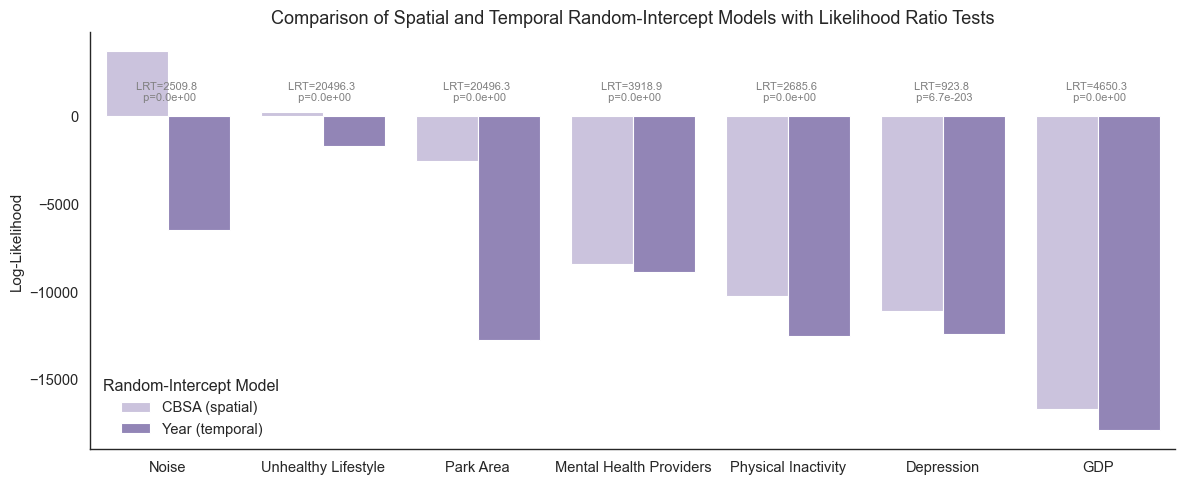

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace factor names for clarity
df['factor'] = df['factor'].replace({
    'Park_Area_Acres': 'Park Area',
    'noise90n': 'Noise',
    'no_time_activity': 'Physical Inactivity',
    'smo_obe_dia': 'Unhealthy Lifestyle',
    'depressed': 'Depression',
    'gdp': 'GDP',
    'mental_health_providers': 'Mental Health Providers',
    'driving_alone_to_work': 'Driving Alone to Work'
})

# Sort factors by CBSA logLik
df = df.sort_values('CBSA_logLik', ascending=False)

# Melt dataframe
df_melted = df.melt(id_vars=['factor', 'p_value', 'LR_stat'], 
                    value_vars=['CBSA_logLik', 'Year_logLik'], 
                    var_name='Model', value_name='LogLik')

# Define academic style
sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# Define colors and legend labels
palette = {'CBSA_logLik': '#C9BFE1', 'Year_logLik': '#8e7dbe'}
legend_labels = {'CBSA_logLik': 'CBSA (spatial)', 'Year_logLik': 'Year (temporal)'}

# Initialize plot
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_melted, x='factor', y='LogLik', hue='Model', palette=palette)

# Add LRT and p-value annotations at bottom
for idx, row in df.iterrows():
    xpos = idx
    ymin = min(row['CBSA_logLik'], row['Year_logLik'])
    ax.text(xpos, 2000,  # fixed position at bottom
            f"LRT={row['LR_stat']:.1f} \n p={row['p_value']:.1e}",
            ha='center', va='top', fontsize=8, color='gray')

# Clean up plot appearance
ax.set_ylabel('Log-Likelihood', fontsize=11)
ax.set_xlabel('')
ax.set_title('Comparison of Spatial and Temporal Random-Intercept Models with Likelihood Ratio Tests', fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fix legend with correct color boxes and labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
ax.legend(handles, new_labels, title='Random-Intercept Model', loc='lower left', frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume df has: ['factor', 'cbsacode', 'Year', 'SSAMI', 'detrended', 'adf_p']

# Sort factors and CBSAs
factors = my_factors       # 7 factors → columns
locations = sorted(df['cbsacode'].unique())    # 72 CBSAs → rows

# Split CBSA list into 12 chunks (6 per page)
chunks = [locations[i:i + 6] for i in range(0, len(locations),6)]

# Loop over chunks
for chunk_idx, chunk in enumerate(chunks):
    nrows = len(chunk)
    ncols = len(factors)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 1), sharex=False, sharey=False)
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for i, loc in enumerate(chunk):
        for j, factor in enumerate(factors):
            ax = axes[i, j]
            subset = df[(df['factor'] == factor) & (df['cbsacode'] == loc)]
            if subset.empty:
                ax.axis('off')
                continue
            
            x = np.arange(len(subset))
            y = subset['SSAMI'].values
            coeffs = np.polyfit(x, y, 1)
            trend = np.polyval(coeffs, x)
            
            ax.plot(subset['Year'], y, linewidth=1)
            ax.plot(subset['Year'], subset['detrended'], linewidth=1)
            ax.plot(subset['Year'], trend, linestyle='--', color='black', linewidth=1)
            
            if i == 0:
                ax.set_title(factor, fontsize=6)
            if j == 0:
                ax.set_ylabel(loc, fontsize=5)
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add red border if non-stationary (p ≥ 0.05)
            adf_p = subset['adf_p_final'].iloc[0]
            if adf_p >= 0.05:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(1.5)
    
    # Add legend once on top
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=6)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # Save each chunk
    plt.savefig(f'panel_chunk_{chunk_idx + 1}_redbox.png', dpi=600, bbox_inches='tight')
    plt.close()

In [14]:
df = pd.read_csv('../00_data/03_analysis_data/all_factor_72_12.csv')

In [27]:
# === Crossed random intercepts via vc_formula (CBSA & Year) ==================
# Works even if cov_re would have been empty; both CBSA and Year variances
# are always in result.vcomp.

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from collections import OrderedDict

# ------------------------------ helpers --------------------------------------

def fit_cbsa_year_model(df, y, cbsa_col="cbsacode", year_col="Year"):
    """
    Fit: y ~ 1 with two crossed random-intercept components for CBSA and Year.
    Uses a dummy group so both components live in `vc_formula`.
    Returns: MixedLMResults
    """
    d = df[[y, cbsa_col, year_col]].dropna().copy()
    # need at least 2 levels in each factor
    if d[cbsa_col].nunique() < 2 or d[year_col].nunique() < 2:
        raise ValueError("Not enough levels in CBSA or Year.")

    d["_all1"] = 1  # dummy single group
    vc = OrderedDict([
        ("CBSA", f"0 + C({cbsa_col})"),
        ("Year", f"0 + C({year_col})")
    ])

    m = smf.mixedlm(f"{y} ~ 1", d, groups=d["_all1"], vc_formula=vc)
    r = m.fit(reml=True, method="lbfgs", maxiter=500, disp=False)
    r._data_used = d  # keep for counts
    r._vc_order = list(vc.keys())  # remember mapping order
    return r

def extract_vcomps_and_icc(res):
    """
    From a MixedLMResults fitted with the function above.
    Returns a dict with variances and ICCs.
    """
    # Residual variance
    sigma2_resid = float(getattr(res, "scale", np.nan))

    # Map vcomp to names using insertion order we stored
    vcomps = {}
    if hasattr(res, "vcomp") and res.vcomp is not None:
        vals = list(map(float, res.vcomp))
        names = getattr(res, "_vc_order", [f"vc{i}" for i in range(len(vals))])
        vcomps = dict(zip(names, vals))

    sigma2_cbsa = vcomps.get("CBSA", np.nan)
    sigma2_year = vcomps.get("Year", np.nan)

    den = sigma2_cbsa + sigma2_year + sigma2_resid
    icc_cbsa = sigma2_cbsa / den if np.isfinite(den) and den > 0 else np.nan
    icc_year = sigma2_year / den if np.isfinite(den) and den > 0 else np.nan

    return {
        "sigma2_CBSA": sigma2_cbsa,
        "sigma2_Year": sigma2_year,
        "sigma2_Residual": sigma2_resid,
        "ICC_CBSA": icc_cbsa,
        "ICC_Year": icc_year,
    }

def summarize_factor(df, y, cbsa_col="cbsacode", year_col="Year"):
    out = {"factor": y}
    try:
        res = fit_cbsa_year_model(df, y, cbsa_col, year_col)
        stats = extract_vcomps_and_icc(res)
        d = res._data_used
        out.update({
            "status": "ok",
            "n_obs": int(res.nobs),
            "n_cbsa": int(d[cbsa_col].nunique()),
            "n_year": int(d[year_col].nunique()),
            "converged": bool(res.converged),
            "logLik": float(res.llf),
            # quick singular flags
            "CBSA_flag": "singular" if np.isfinite(stats["sigma2_CBSA"]) and stats["sigma2_CBSA"] < 1e-8 else "ok",
            "Year_flag": "singular" if np.isfinite(stats["sigma2_Year"]) and stats["sigma2_Year"] < 1e-8 else "ok",
        })
        out.update(stats)
    except Exception as e:
        out.update({"status": f"error: {e}"})
    return out

def icc_table(
    df,
    factor_cols=None,
    cbsa_col="cbsacode",
    year_col="Year",
    id_cols=("cbsacode","Year"),
):
    """
    Run the crossed-RE model for each factor and return a tidy summary DataFrame.
    If factor_cols is None, numeric non-ID columns are inferred.
    """
    if factor_cols is None:
        factor_cols = [c for c in df.columns
                       if c not in id_cols and np.issubdtype(df[c].dtype, np.number)]

    rows = [summarize_factor(df, y, cbsa_col, year_col) for y in factor_cols]
    cols = [
        "factor","status","n_obs","n_cbsa","n_year","converged","logLik",
        "sigma2_CBSA","sigma2_Year","sigma2_Residual","ICC_CBSA","ICC_Year",
        "CBSA_flag","Year_flag"
    ]
    out = pd.DataFrame(rows)
    return out[[c for c in cols if c in out.columns]]

# ------------------------------ usage ----------------------------------------
# df = pd.read_csv("../00_data/03_analysis_data/all_factor_72_12.csv")
# table = icc_table(df, factor_cols=["GDP","NOI","PARK","PI","DEP","MHP","UNH"],
#                   cbsa_col="cbsacode", year_col="Year")
# print(table.to_string(index=False))
# table.to_csv("icc_summary.csv", index=False)

In [28]:
df = pd.read_csv('../00_data/03_analysis_data/all_factor_72_12.csv')

df = df.rename(columns={
    'Park_Area_Acres': 'PARK',
    'noise90n': 'NOI',
    'no_time_activity': 'PI',
    'smo_obe_dia': 'UNH',
    'depressed': 'DEP',
    'gdp': 'GDP',
    'mental_health_providers': 'MHP'
})


cbsa_col = "cbsacode"
year_col = "Year"
factor_cols = ['GDP','NOI','PARK','PI','DEP','MHP','UNH']

results = icc_table(df, factor_cols, cbsa_col=cbsa_col, year_col=year_col)
print(results.to_string(index=False))
results.to_csv("icc_summary.csv", index=False)

factor status  n_obs  n_cbsa  n_year  converged        logLik  sigma2_CBSA  sigma2_Year  sigma2_Residual  ICC_CBSA  ICC_Year CBSA_flag Year_flag
   GDP     ok    864      72      12       True -16569.692058 6.214615e+16 5.406151e+14     1.597960e+15  0.966733  0.008410        ok        ok
   NOI     ok    864      72      12       True   3693.122311 1.705112e+04 1.083958e+03     9.448004e-07  0.940229  0.059771        ok        ok
  PARK     ok    864      72      12       True  -2586.389557 3.564216e+10 2.265754e+09     1.974769e+00  0.940230  0.059770        ok        ok
    PI     ok    864      72      12       True -10239.731422 1.911122e+11 3.864576e+10     5.290730e+08  0.829887  0.167816        ok        ok
   DEP     ok    864      72      12       True -11000.399577 1.851501e+11 1.158227e+09     3.907146e+09  0.973370  0.006089        ok        ok
   MHP     ok    864      72      12       True  -8295.091057 4.059984e+07 3.946778e+06     8.912240e+06  0.759460  0.073828      